In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import numpy as np

In [4]:
# Step 1: Load and preprocess data
def read_corpus(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().lower().split()
    return text

def build_vocab(corpus, vocab_size=10000):
    word_counts = Counter(corpus)
    vocab = [word for word, _ in word_counts.most_common(vocab_size)]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word

def generate_skipgram_pairs(corpus, window_size, word2idx):
    pairs = []
    for i, word in enumerate(corpus):
        target = word2idx.get(word)
        if target is None:
            continue
        for j in range(max(0, i - window_size), min(len(corpus), i + window_size + 1)):
            if i != j:
                context = word2idx.get(corpus[j])
                if context is not None:
                    pairs.append((target, context))
    return pairs

In [5]:
# Step 2: Build the Skip-gram model
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.output_layer = nn.Linear(embed_size, vocab_size)

    def forward(self, target_word):
        embed = self.embeddings(target_word)
        output = self.output_layer(embed)
        return output

In [6]:
# Step 3: Training the model
def train_model(corpus_file, window_size=5, embed_size=100, epochs=5, batch_size=64, learning_rate=0.001):
    corpus = read_corpus(corpus_file)
    word2idx, idx2word = build_vocab(corpus)
    pairs = generate_skipgram_pairs(corpus, window_size, word2idx)

    vocab_size = len(word2idx)
    model = Word2Vec(vocab_size, embed_size)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # DataLoader for batching
    def batch_data(pairs, batch_size):
        np.random.shuffle(pairs)
        for i in range(0, len(pairs), batch_size):
            batch = pairs[i:i+batch_size]
            yield torch.LongTensor([pair[0] for pair in batch]), torch.LongTensor([pair[1] for pair in batch])

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for target_words, context_words in batch_data(pairs, batch_size):
            optimizer.zero_grad()
            output = model(target_words)
            loss = loss_function(output, context_words)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch: {epoch+1}, Loss: {total_loss/len(pairs):.4f}')
    
    # Save the model and embeddings
    torch.save(model.state_dict(), 'word2vec_skipgram.pth')
    return model, word2idx, idx2word



In [8]:
# Example usage
corpus_file = 'data/vol_4.txt'
model, word2idx, idx2word = train_model(corpus_file, embed_size=100)

/home/biswajit/.local/lib/python3.10/site-packages/torch/autograd/graph.py:769: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1, Loss: 0.1055
Epoch: 2, Loss: 0.1011
Epoch: 3, Loss: 0.0999
Epoch: 4, Loss: 0.0989
Epoch: 5, Loss: 0.0981


In [16]:
model.embeddings.weight.data.cpu().numpy().shape

(10000, 100)

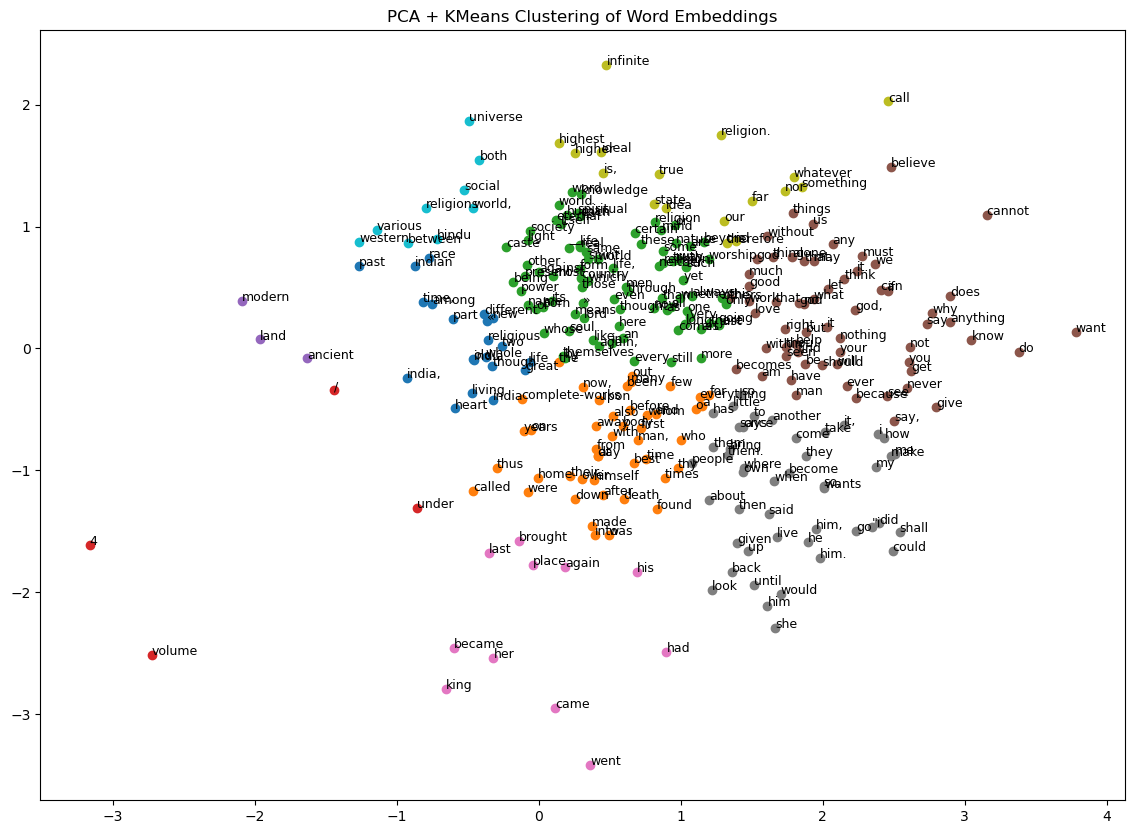

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Extract embeddings from the trained model
def extract_embeddings(model, vocab_size):
    embeddings = model.embeddings.weight.data.cpu().numpy()
    return embeddings[:vocab_size]

# Step 2: Apply PCA to reduce dimensions to 2D
def reduce_embeddings_pca(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

# Step 3: Apply KMeans for clustering
def apply_kmeans(embeddings, num_clusters=10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    return cluster_labels

# Step 4: Plot the PCA-reduced embeddings with KMeans clusters
def plot_clusters(embeddings, cluster_labels, idx2word, n_words=300):
    plt.figure(figsize=(14, 10))
    for i in range(n_words):
        plt.scatter(embeddings[i, 0], embeddings[i, 1], c=f'C{cluster_labels[i]}', label=f'Cluster {cluster_labels[i]}' if i == 0 else "")
        plt.text(embeddings[i, 0], embeddings[i, 1], idx2word[i], fontsize=9)
    
    plt.title('PCA + KMeans Clustering of Word Embeddings')
    plt.show()

# Example usage
vocab_size = len(word2idx)
embeddings = extract_embeddings(model, vocab_size)

# Reduce dimensions with PCA
reduced_embeddings = reduce_embeddings_pca(embeddings, n_components=2)

# Apply KMeans clustering
num_clusters = 10  # Set your desired number of clusters
cluster_labels = apply_kmeans(reduced_embeddings, num_clusters=num_clusters)

# Visualize the clustered embeddings
plot_clusters(reduced_embeddings, cluster_labels, idx2word, n_words=300)  # Adjust n_words as needed


In [35]:
import pandas as pd

# Define the path to your text file
file_path = 'ws353simrel/wordsim353_sim_rel/wordsim_relatedness_goldstandard.txt'  # Replace with your actual file name

# Read the text file into a DataFrame
df = pd.read_csv(file_path, sep='\t', header=None, names=['Word1', 'Word2', 'Score'])

# Display the DataFrame
print(df)


         Word1      Word2  Score
0     computer   keyboard   7.62
1    Jerusalem     Israel   8.46
2       planet     galaxy   8.11
3       canyon  landscape   7.53
4         OPEC    country   5.63
..         ...        ...    ...
247    rooster     voyage   0.62
248       noon     string   0.54
249      chord      smile   0.54
250  professor   cucumber   0.31
251       king    cabbage   0.23

[252 rows x 3 columns]


In [36]:
import pandas as pd

# Step 1: Read the text file into a DataFrame


file_path = 'data/vol_4.txt'  # Replace with your actual file name
texts = read_corpus(file_path)

# Step 2: Define your list of words
word_list = texts  # Replace with your actual list of words

# Step 3: Filter the DataFrame to keep only pairs where both words are in the list
filtered_df = df[df['Word1'].isin(word_list) & df['Word2'].isin(word_list)]

# Display the filtered DataFrame
print(filtered_df)


      Word1     Word2  Score
2    planet    galaxy   8.11
5       day    summer   3.94
6       day      dawn   7.53
8    planet    people   5.75
12    money      bank   8.50
..      ...       ...    ...
238    holy       sex   1.62
240   drink       ear   1.31
244    monk     slave   0.92
246   sugar  approach   0.88
249   chord     smile   0.54

[92 rows x 3 columns]


In [50]:
model_10, word2idx_10, idx2word_10 = train_model(corpus_file, embed_size=10)

Epoch: 1, Loss: 0.1067
Epoch: 2, Loss: 0.1020
Epoch: 3, Loss: 0.1016
Epoch: 4, Loss: 0.1014
Epoch: 5, Loss: 0.1012


In [51]:
model_50, word2idx_50, idx2word_50 = train_model(corpus_file, embed_size=50)


Epoch: 1, Loss: 0.1057
Epoch: 2, Loss: 0.1016
Epoch: 3, Loss: 0.1008
Epoch: 4, Loss: 0.1002
Epoch: 5, Loss: 0.0997
